In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SGLBO

## PQC

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


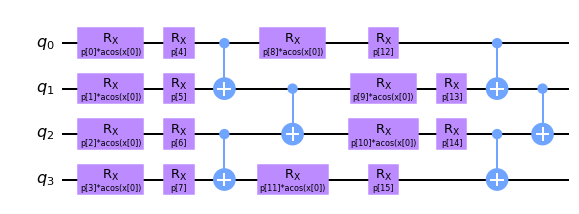

In [2]:
executor = Executor("qasm_simulator")
executor.set_shots(5000)

nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

## Observable

In [3]:
op = SummedPaulis(nqubits)
print(op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


In [4]:
def sigmoid(x, a, b, c):
    return 1 / (1 + np.exp(-a * (x - b) / c))

In [5]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.random.rand(op.num_parameters)

x_train = np.arange(-1, 1.1, 0.1)
y_train = sigmoid(x_train, 5, 0, 1)

In [6]:
#x0 = [[i * 0.02] for i in range(15)]
x0 = [[1e-6], [2e-6], [1e-5], [2e-5]]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(-1e3, 0.2)], "log_file": "sglbo_sigmoid_noise_no_surrogate.log",
                     "bo_n_calls": 60, "bo_x0_points": x0, "maxiter": 300, "min_surrogate":False}

qnn_simulator_sglbo = QNNRegressor(
    pqc,
    op,
    executor,
    SquaredLoss(),
    SGLBO(optimizer_options),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, 
    parameter_seed=124
)

qnn_simulator_sglbo.fit(x_train, y_train)

fit:   0%|          | 0/300 [00:00<?, ?it/s]total_shots 3990000
gradient [-1.14363075 -0.02827539  0.45628177 -4.27069079 -1.22761744  0.14709281
  0.69379555 -1.33535919  5.82609613  0.22044176 -1.00863313 -4.10978904
  2.01880683  0.3006907  -0.43188796 -1.37835589 -4.84328794  0.31268702
 -0.94947297 -0.62177344 -0.18144966]
finite_diff_grad [ 1.024594   -5.21846712  8.93052401 -5.51178344  3.02290757  3.17437354
  2.84008921 -0.88135217  9.05231422  1.50832018  2.12075505 -3.20783385
  0.06566544  2.91477832 -2.80113551 -4.58741281 -3.13378771 -0.50855063
 -2.45647298 -1.99044891 -1.61036061]
BOP  fval:  3.7851530902477037  x:  [1e-06]
BOP  fval:  3.7980615785721565  x:  [2e-06]
BOP  fval:  3.6738528770425054  x:  [1e-05]
BOP  fval:  3.6299120043659108  x:  [2e-05]
BOP  fval:  12.556857628512056  x:  [0.19999418924994572]
BOP  fval:  3.538594350974725  x:  [0.0015279008554543866]
BOP  fval:  1.3492814188709439  x:  [0.04745914899598108]
BOP  fval:  0.9665164955787111  x:  [0.083738

## predict vs. actual function